## Entrenando un primer modelo

### Carga de datos en formato numérico

Ahora llegamos a la parte en la que vamos a construir un primer modelo. Para esto voy a cargar un conjunto de datos que se encuentra en la fuente que representa al mismo que exploramos antes pero fue llevado a valores numéricos para poder entrenar modelos con él.

En este nuevo conjunto de datos aparecen más columnas que intuyo provienen de algún one hot encoding o alguna técnica relacionada pero en principio no tenemos forma de identificar las columnas más que comparar algunos valores. Por lo tanto voy a considerar a este conjunto de datos en su completitud para entrenar al modelo.

Lo ideal sería hacer una selección de features considerando la exploración que hicimos antes y empezar desde un modelo más simple, pero a efectos prácticos de este análisis de fairness voy a utilizar el conjunto de datos numérico tal como está.

In [ ]:
df_numeric = pd.read_csv('./drive/MyDrive/German_data_equidad/german.data-numeric', sep=' ', header=None, skipinitialspace=True)

In [ ]:
df_numeric.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,6,4,12,5,5,3,4,1,67,...,0,1,0,0,1,0,0,1,1,NaN
1,2,48,2,60,1,3,2,2,1,22,...,0,1,0,0,1,0,0,1,2,NaN
2,4,12,4,21,1,4,3,3,1,49,...,0,1,0,0,1,0,1,0,1,NaN
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,1,1,NaN
4,1,24,3,49,1,3,3,4,4,53,...,0,1,0,0,0,0,0,1,2,NaN


Podemos ver que la última columna tiene valores faltantes, usemos la función ".info()" de pandas para ver si esto se extiende a lo largo de la columna:

In [ ]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   int64  
 1   1       1000 non-null   int64  
 2   2       1000 non-null   int64  
 3   3       1000 non-null   int64  
 4   4       1000 non-null   int64  
 5   5       1000 non-null   int64  
 6   6       1000 non-null   int64  
 7   7       1000 non-null   int64  
 8   8       1000 non-null   int64  
 9   9       1000 non-null   int64  
 10  10      1000 non-null   int64  
 11  11      1000 non-null   int64  
 12  12      1000 non-null   int64  
 13  13      1000 non-null   int64  
 14  14      1000 non-null   int64  
 15  15      1000 non-null   int64  
 16  16      1000 non-null   int64  
 17  17      1000 non-null   int64  
 18  18      1000 non-null   int64  
 19  19      1000 non-null   int64  
 20  20      1000 non-null   int64  
 21  21      1000 non-null   int64  
 22  2

Vemos que es una columna vacía, por lo tanto simplemente la eliminamos:

In [ ]:
# eliminamos la última columna
df_numeric = df_numeric.iloc[:, :-1]

### Entrenamiento del modelo

Ahora la idea es entrenar un modelo de aprendizaje automático y dada la forma de nuestra variable objetivo lo más sensato es utilizar un modelo de regresión logística, aunque podríamos usar otro tipo de modelos más complejos.

En este caso elijo usar a la regresión logística por su simpleza en términos de implementación y facilidad para ser interpretado, lo que a su vez facilita el análisis de equidad.

Empiezo por separar en matriz de diseño y variable objetivo y hacer un mapeo de los valores de la variable objetivo para que estos estén representados en términos de 0 y 1.

* 0 -> Bajo riesgo crediticio
* 1 -> Alto riesgo crediticio

In [ ]:
X = df_numeric.iloc[:, :-1]
y = df_numeric.iloc[:, -1].map({1: 0, 2: 1})
indices = X.index

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X.values, y.values, indices, test_size=0.2, random_state=42)

# Agrego intercepto
X_train_design = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test_design = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

In [ ]:
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

def neg_log_likelihood(beta, X, y):
    nu = X @ beta
    vinculo = sigmoide(nu)
    return -np.sum(y * np.log(vinculo + 1e-10) + (1 - y) * np.log(1 - vinculo + 1e-10))

In [ ]:
from scipy.optimize import minimize

# Inicializamos coeficientes
initial_beta = np.zeros(X_train_design.shape[1])

# Ajuste con minimize
res = minimize(neg_log_likelihood, initial_beta, args=(X_train_design, y_train), method='BFGS')

# Coeficientes resultantes
beta_hat = res.x

In [ ]:
beta_hat

array([ 3.88049067, -0.54589779,  0.02723487, -0.38685489,  0.00560824,
       -0.16011435, -0.1460473 , -0.17843473,  0.03459702,  0.15777867,
       -0.0244037 , -0.34413083,  0.2964565 ,  0.02209763, -0.2104713 ,
       -1.33135742,  0.72477767, -0.89810282,  0.84817875,  0.74543736,
        0.06232551, -0.4395021 , -0.92887852, -0.23123497, -0.06263938])

In [ ]:
y_pred_probs = sigmoide(X_test_design @ beta_hat)

y_pred = (y_pred_probs >= 0.5).astype(int)

Ahora con un modelo entrenado y predicciones realizadas no queda más que hacer un análisis de las métricas del modelo.

### Mirando las métricas del modelo

Ahora seguimos con la evaluación de las distintas métricas del modelo en general usando el conjunto de test. Para empezar voy a generar un reporte de clasificación que acumule métricas varias:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       141
           1       0.66      0.53      0.58        59

    accuracy                           0.78       200
   macro avg       0.74      0.71      0.72       200
weighted avg       0.77      0.78      0.77       200



Podemos ver que en general el modelo tiene un buen desempeño identificando a los solicitantes de bajo riesgo mientras que su desempeño cae al identificar a los solicitantes de alto riesgo. Podemos suponer inicialmente que esto es debido al desequilibrio entre ambas categorías pero pueden haber otros motivos.

Si lo comparamos con los modelos que indica la fuente que fueron entrenados con estos datos, esta regresión logística entra dentro del rango en términos de precision y accuracy para modelos de su mismo tipo.

Ahora generemos una matriz de confusión para ver el desempeño del modelo identificando instancias:

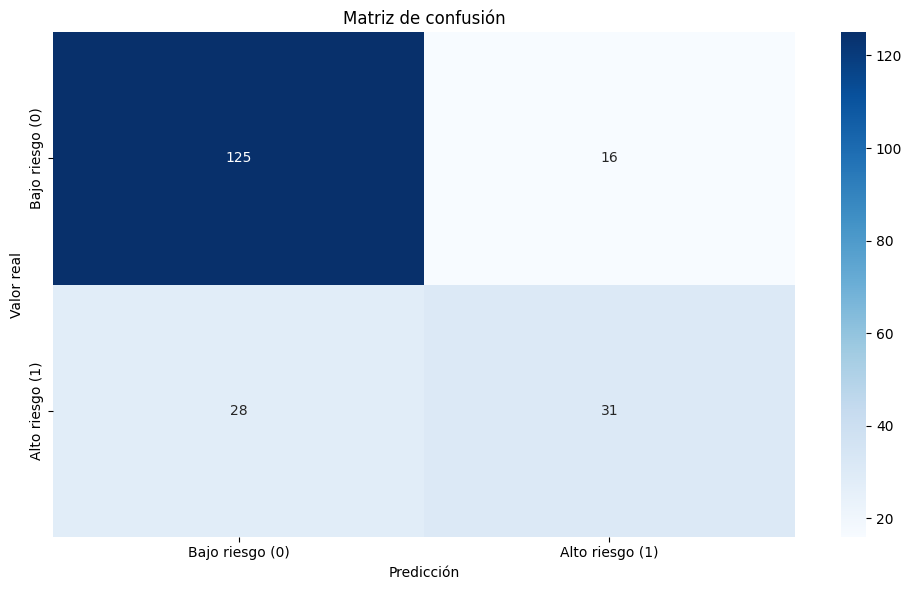

In [ ]:
cm = confusion_matrix(y_test, y_pred)
labels = ['Bajo riesgo (0)', 'Alto riesgo (1)']

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión')
plt.tight_layout()
plt.show()

Para leer esta matriz de confusión tenemos que considerar:

* Los verdaderos positivos son los solicitantes que fueron clasificados de bajo riesgo por el modelo y que en la realidad también tenían la misma clasificación.
* Los verdaderos negativos son los solicitantes que fueron clasificados de alto riesgo por el modelo y que en la realidad también tenían la misma clasificación.
* Los falsos positivos son los solicitantes que fueron clasificados de bajo riesgo por el modelo y que en la realidad fueron clasificados como de alto riesgo.
* Los falsos negativos son los solicitantes que fueron clasificados de alto riesgo por el modelo y que en la realidad fueron clasificados como de bajo riesgo.

Dejando esto en claro podemos remarcar los siguientes puntos:

*  El modelo logró identificar correctamente en la mayoría de los casos a los solicitantes de bajo riesgo con un total de 125 verdaderos positivos.

* Podemos notar que también tuvo varios casos de falsos positivos con 28 en total, esto representa al tipo de error que para ojos del banco es más grave ya que son solicitantes a los cuales se les otorgaría un préstamo y son realmente de alto riesgo crediticio.

* Luego tuvo 16 casos de falsos negativos que si bien es un error no es tan grave como el mencionado anteriormente, además que no es un número alarmante.

* Logró identificar correctamente a 31 solicitantes de alto riesgo pero es un número que podría mejorar.

Con este análisis en general del modelo ahora podemos pasar a hacer algo similar pero separando por género del solicitante, esto nos permitirá empezar a analizar aspectos de la equidad presente en este modelo e identificar potenciales sesgos.